<a href="https://colab.research.google.com/github/Dipto1971/100xDevsAssignments/blob/main/Political%20Crowdsourcing/Political_Crowdsourcing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats import ttest_ind, chi2_contingency, f_oneway
from scipy.stats import shapiro, normaltest
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from scipy.stats import ttest_ind, chi2_contingency, f_oneway
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from statsmodels.formula.api import ols

In [78]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/PC-SM.csv')

In [79]:
label_columns = ['PS1', 'PS2', 'PS3', 'PS4', 'PS5', 'PS6', 'PS7', 'PS8', 'PS9'
                  , 'SMUT1', 'SMUT2', 'SMUT3', 'SMUT4', 'SMUT5', 'SMUT6', 'SMUT7', 'SMUT8', 'SMUT9'
                  , 'OSC1' , 'OSC2' , 'OSC3' , 'OSC4' , 'OSC5' , 'OSC6'
                  , 'VONP1', 'VONP2', 'VONP3', 'VONP4', 'VONP5', 'VONP6', 'VONP7', 'VONP8'
                  , 'VOFP1', 'VOFP2', 'VOFP3', 'VOFP4', 'VOFP5', 'VOFP6', 'VOFP7'
                  , 'PLT1', 'PLT2', 'PLT3', 'PLT4', 'PLT5', 'PLT6', 'PLT7'
                  , 'Gender', 'Age', 'MS', 'RL', 'PI', 'Education Level']

label_columns_to_measure = ['Partisanship',
                            'Social Media Utilization',
                            'Online Social Capital',
                            'Voluntary Online Political Participation',
                            'Voluntary Offline Political Participation',
                            'Political Trust']

In [80]:
# Define variable groups with their respective column names
variable_groups = {
    'Partisanship': ['PS1', 'PS2', 'PS3', 'PS4', 'PS5', 'PS6', 'PS7', 'PS8', 'PS9'],
    'Social Media Utilization': ['SMUT1', 'SMUT2', 'SMUT3', 'SMUT4', 'SMUT5', 'SMUT6', 'SMUT7', 'SMUT8', 'SMUT9'],
    'Online Social Capital': ['OSC1', 'OSC2', 'OSC3', 'OSC4', 'OSC5', 'OSC6'],
    'Voluntary Online Political Participation': ['VONP1', 'VONP2', 'VONP3', 'VONP4', 'VONP5', 'VONP6', 'VONP7', 'VONP8'],
    'Voluntary Offline Political Participation': ['VOFP1', 'VOFP2', 'VOFP3', 'VOFP4', 'VOFP5', 'VOFP6', 'VOFP7'],
    'Political Trust': ['PLT1', 'PLT2', 'PLT3', 'PLT4', 'PLT5', 'PLT6', 'PLT7']
}

In [81]:
# Initial exploration
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 472 entries, 0 to 471
Data columns (total 55 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   ID               472 non-null    int64
 1   PS1              472 non-null    int64
 2   PS2              472 non-null    int64
 3   PS3              472 non-null    int64
 4   PS4              472 non-null    int64
 5   PS5              472 non-null    int64
 6   PS6              472 non-null    int64
 7   PS7              472 non-null    int64
 8   PS8              472 non-null    int64
 9   PS9              472 non-null    int64
 10  SMUT1            472 non-null    int64
 11  SMUT2            472 non-null    int64
 12  SMUT3            472 non-null    int64
 13  SMUT4            472 non-null    int64
 14  SMUT5            472 non-null    int64
 15  SMUT6            472 non-null    int64
 16  SMUT7            472 non-null    int64
 17  SMUT8            472 non-null    int64
 18  SMUT9     

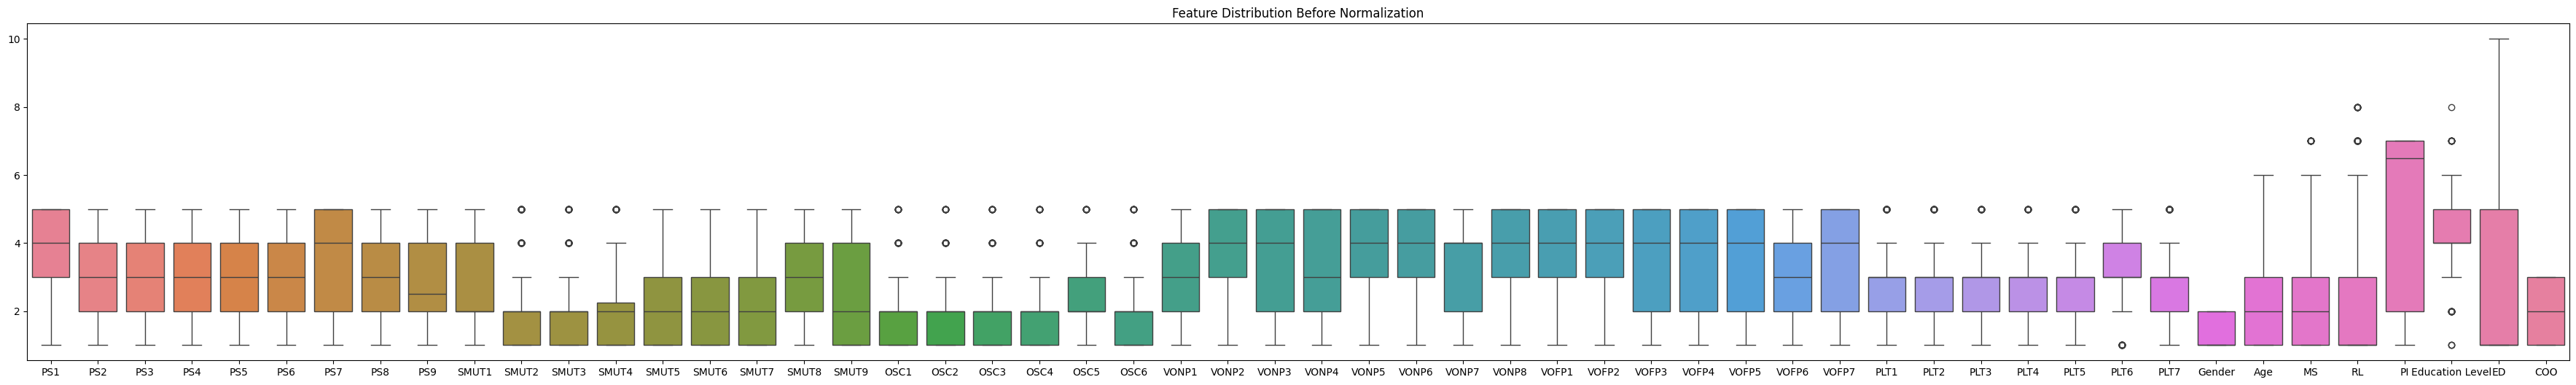

In [82]:
# Visualize before and after normalization
plt.figure(figsize=(45, 6))
sns.boxplot(data=df.iloc[:, 1:])
plt.title("Feature Distribution Before Normalization")
plt.show()

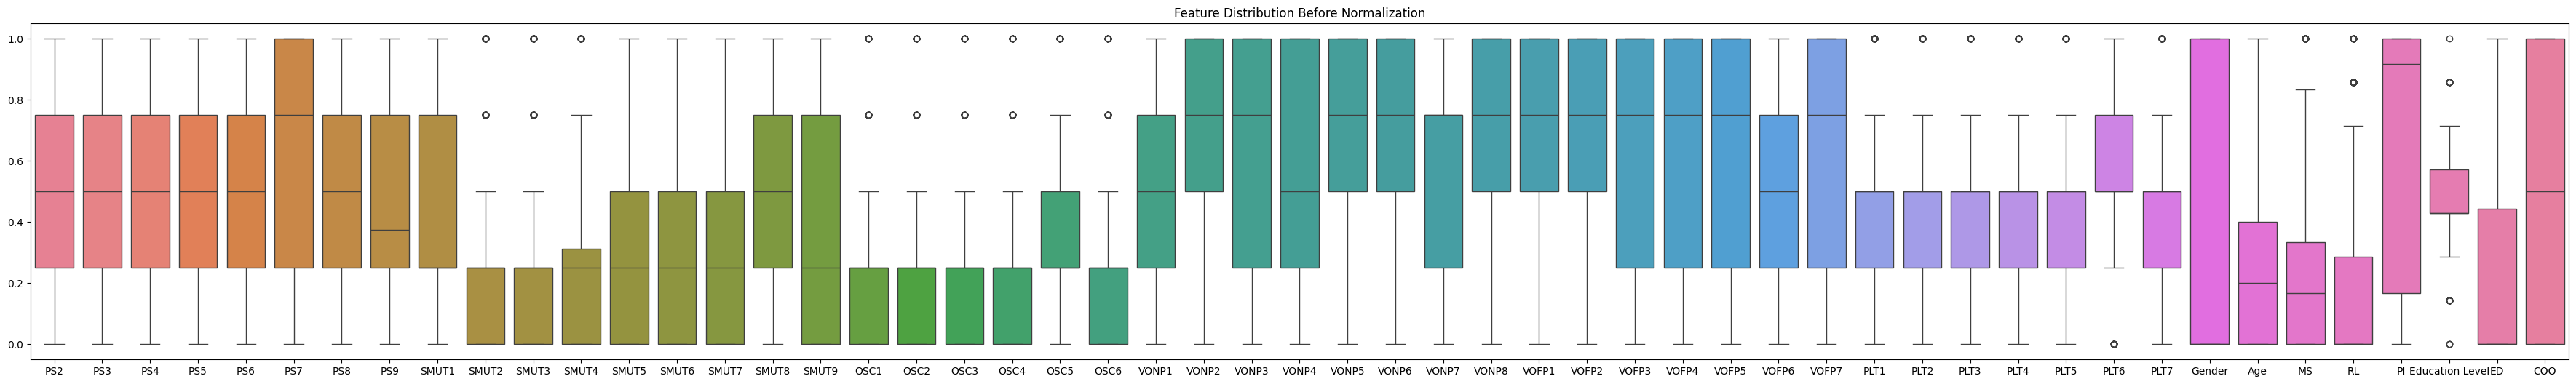

In [83]:
scaler = MinMaxScaler()
normalized_data = pd.DataFrame(scaler.fit_transform(df.iloc[:, 1:]), columns=df.columns[1:])
# Visualize before and after normalization
plt.figure(figsize=(45, 6))
sns.boxplot(data=normalized_data.iloc[:, 1:])
plt.title("Feature Distribution Before Normalization")
plt.show()

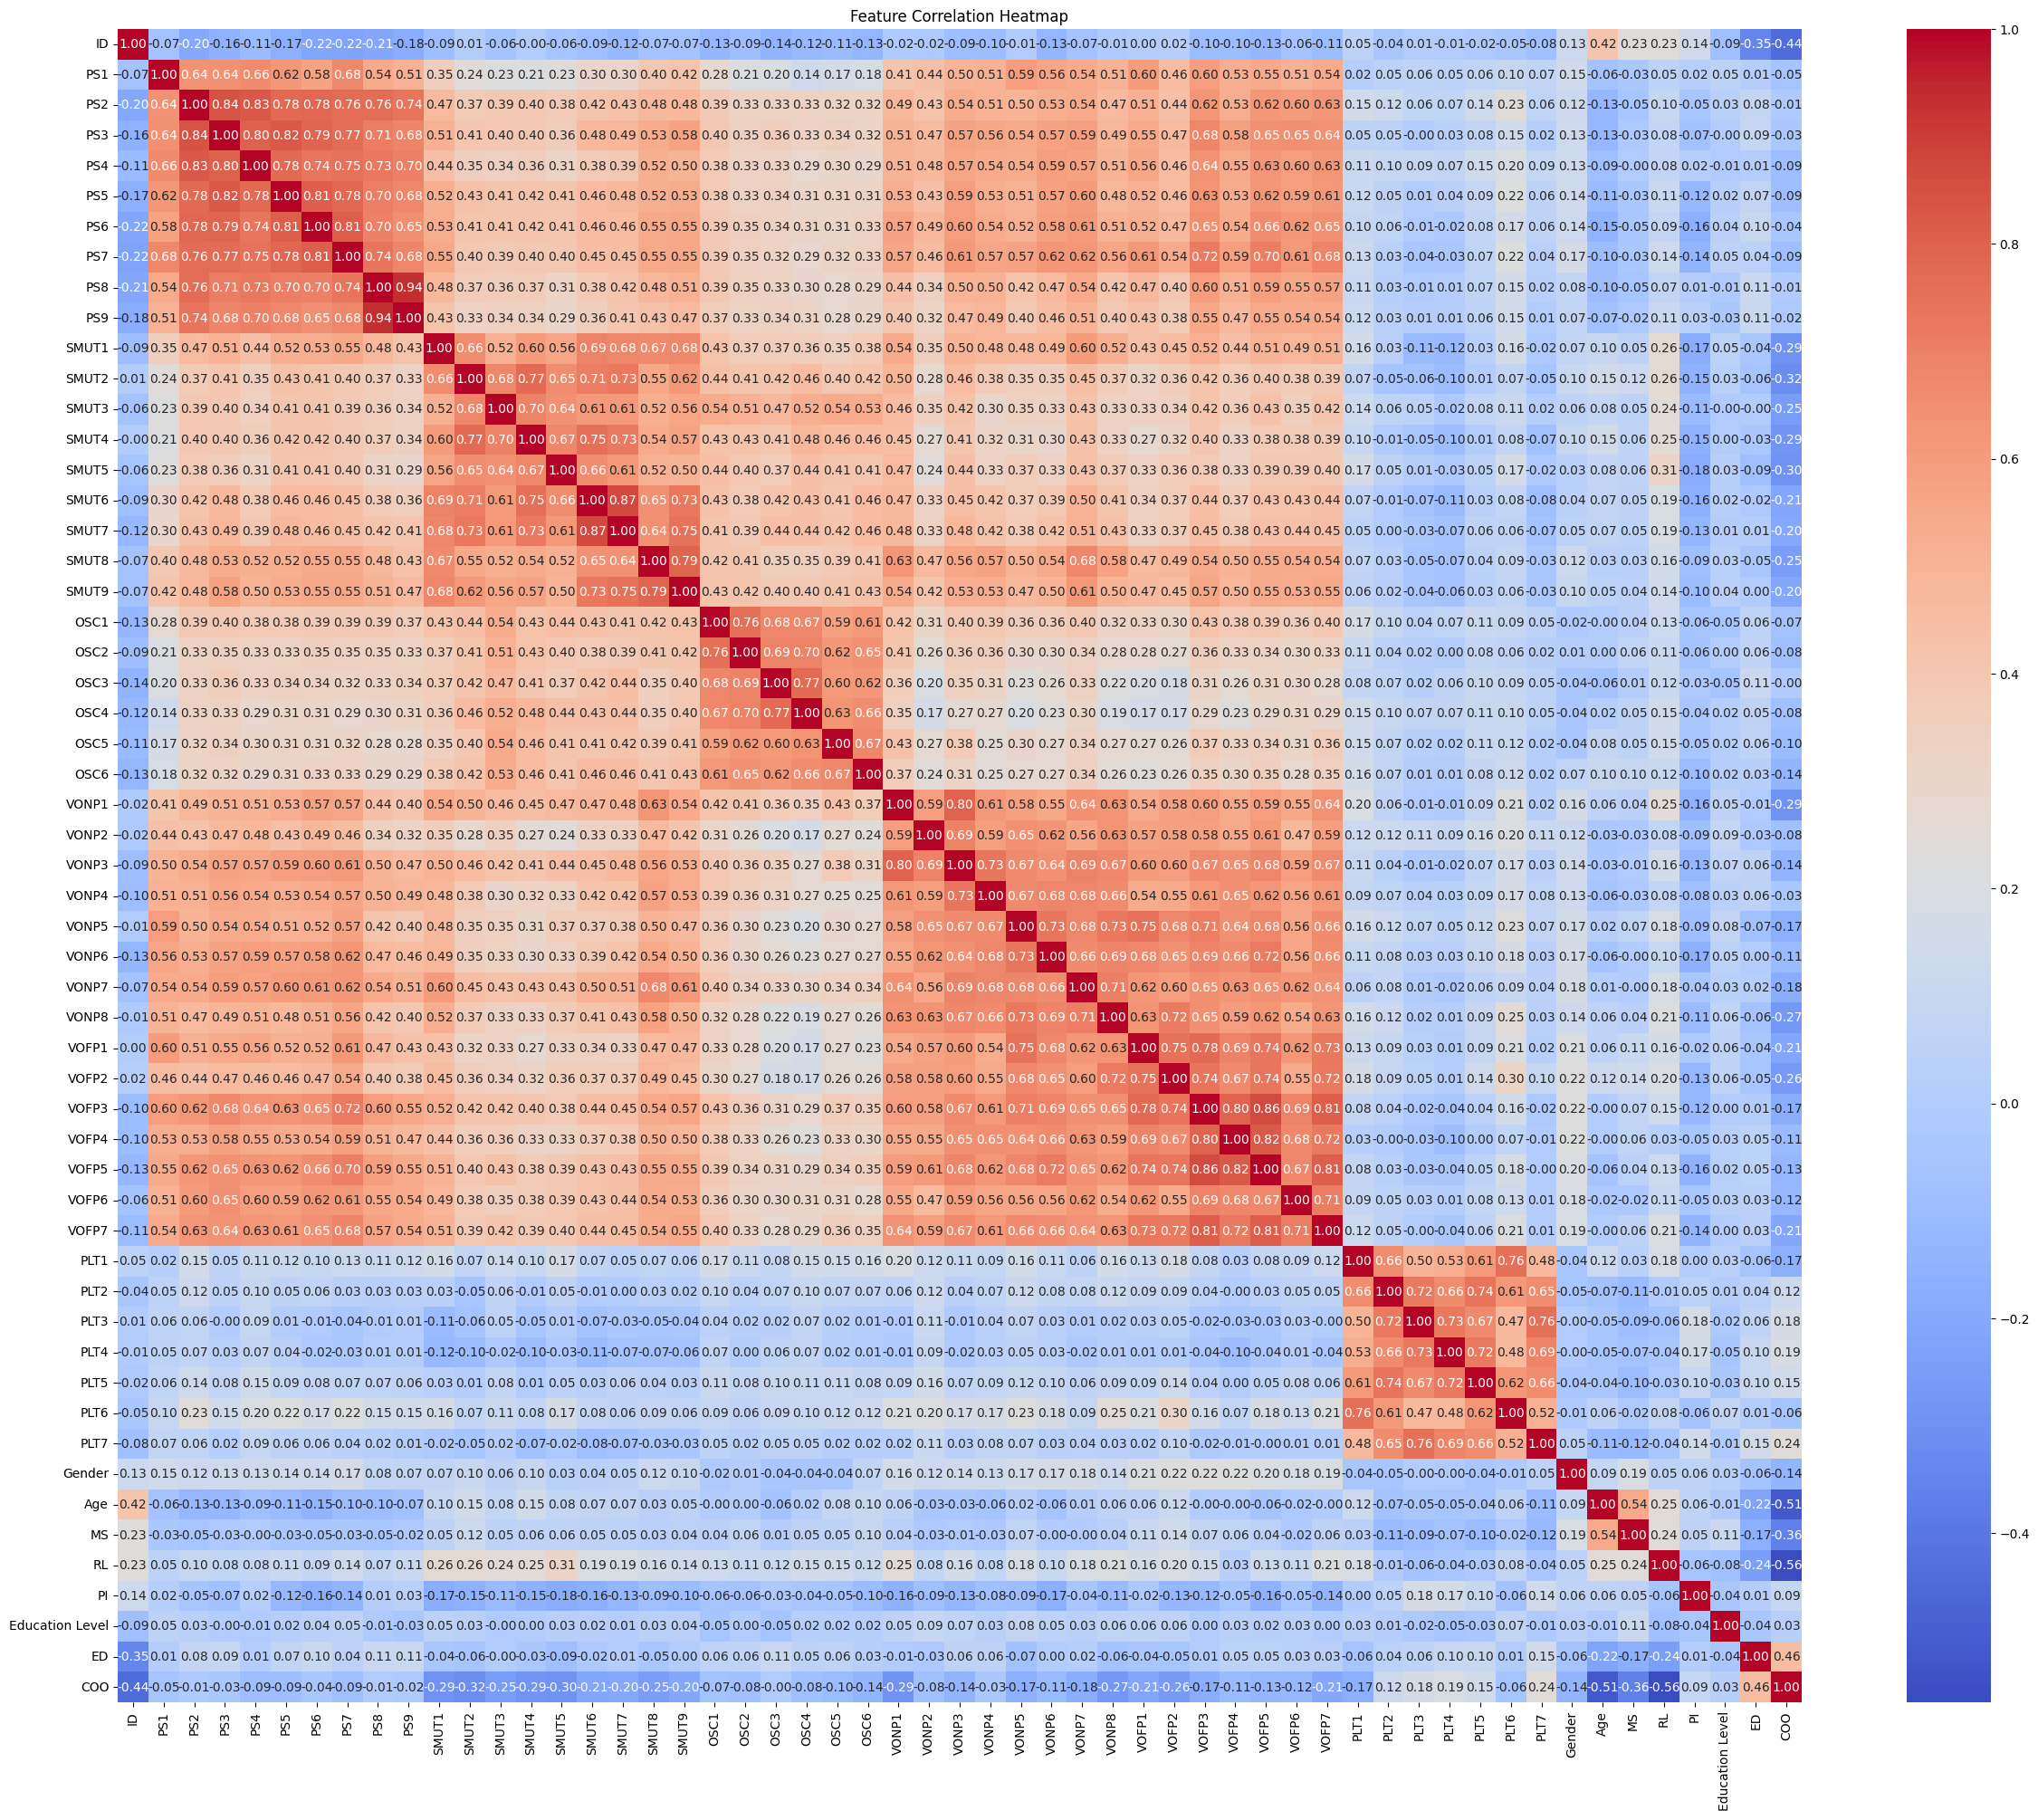

In [84]:
# Step 2: Feature Engineering
# Correlation matrix to identify relevant features
# Compute correlation matrix
correlation_matrix = df.corr()

# Plot heatmap
plt.figure(figsize=(30, 24))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

In [85]:
import itertools

def find_high_correlations(dataframe, plt_prefix, plt_range, threshold=0.1):
    """
    Find correlations of features starting with a specific prefix (e.g., PLT) with other features.

    Parameters:
        dataframe (pd.DataFrame): The input DataFrame.
        plt_prefix (str): The prefix of the features to consider (e.g., 'PLT').
        plt_range (int): The range of PLT features (e.g., 9 for PLT1 to PLT9).
        threshold (float): The correlation threshold. Defaults to 0.30.

    Returns:
        list of tuples: List containing tuples of feature pairs and their correlation value.
    """
    # Generate the list of PLT features based on the range
    plt_features = [f"{plt_prefix}{i}" for i in range(1, plt_range + 1)]

    # Ensure the PLT features exist in the DataFrame
    plt_features = [feature for feature in plt_features if feature in dataframe.columns]

    # Calculate the correlation matrix
    correlation_matrix = dataframe.corr()

    # Find correlations for PLT features with other features
    high_corr_pairs = [
        (plt_feature, column, correlation_matrix.loc[plt_feature, column])
        for plt_feature in plt_features
        for column in correlation_matrix.columns
        if (
            plt_feature != column and  # Exclude self-correlation
            (correlation_matrix.loc[plt_feature, column]) > threshold and
            correlation_matrix.loc[plt_feature, column] != 1  # Exclude perfect correlation
            and column not in plt_features
        )
    ]

    # Sort by absolute correlation in descending order
    high_corr_pairs.sort(key=lambda x: (x[2]), reverse=True)

    return high_corr_pairs

PLT_correlated = (find_high_correlations(df, 'PLT', 9))
display(PLT_correlated)

[('PLT6', 'VOFP2', 0.3026207538560495),
 ('PLT6', 'VONP8', 0.24786660803174348),
 ('PLT7', 'COO', 0.23878394307727566),
 ('PLT6', 'PS2', 0.23499300356919667),
 ('PLT6', 'VONP5', 0.22715029034535042),
 ('PLT6', 'PS7', 0.21917472911467104),
 ('PLT6', 'PS5', 0.21616724593548717),
 ('PLT6', 'VONP1', 0.21374147540415683),
 ('PLT6', 'VOFP7', 0.2088674000227886),
 ('PLT6', 'VOFP1', 0.20535255573619834),
 ('PLT6', 'VONP2', 0.2046711425999222),
 ('PLT6', 'PS4', 0.19783448628662872),
 ('PLT1', 'VONP1', 0.19762257885180376),
 ('PLT4', 'COO', 0.18886761362767332),
 ('PLT1', 'RL', 0.18277414458024696),
 ('PLT6', 'VOFP5', 0.1782679635119632),
 ('PLT1', 'VOFP2', 0.1782105593018569),
 ('PLT3', 'COO', 0.17816457362697946),
 ('PLT3', 'PI', 0.17770656467095583),
 ('PLT6', 'VONP6', 0.17706372426537048),
 ('PLT1', 'OSC1', 0.17488981188757366),
 ('PLT6', 'VONP4', 0.17426480806984695),
 ('PLT1', 'SMUT5', 0.17322372523958707),
 ('PLT6', 'PS6', 0.1717150642405419),
 ('PLT6', 'VONP3', 0.1693691350827389),
 ('PL

In [86]:
def plot_encoded_features(dataframe, feature_prefix, feature_range):
    """
    Plot countplots for label-encoded features with a specific prefix and range, all in one display.

    Parameters:
        dataframe (pd.DataFrame): The input DataFrame.
        feature_prefix (str): The prefix of the features to consider (e.g., 'VONP').
        feature_range (int): The number of features to consider (e.g., 8 for VONP1 to VONP8).
    """
    # Generate the list of features based on the prefix and range
    features = [f"{feature_prefix}{i}" for i in range(1, feature_range + 1)]

    # Ensure the features exist in the DataFrame
    features = [feature for feature in features if feature in dataframe.columns]

    # Create a grid of countplots
    num_features = len(features)
    cols = 3  # Number of columns in the grid
    rows = -(-num_features // cols)  # Calculate rows needed (ceiling division)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
    axes = axes.flatten()  # Flatten axes array for easy iteration

    for idx, feature in enumerate(features):
        sns.countplot(data=dataframe, x=feature, palette="coolwarm", ax=axes[idx])
        axes[idx].set_title(f"Countplot of {feature}")
        axes[idx].set_xlabel(feature)
        axes[idx].set_ylabel("Count")

    # Turn off any unused subplots
    for idx in range(num_features, len(axes)):
        axes[idx].set_visible(False)

    plt.tight_layout()
    plt.show()

In [87]:
features_to_keep = set()
for feature1, feature2, _ in PLT_correlated:
    features_to_keep.add(feature1)
    features_to_keep.add(feature2)

# Step 2: Filter the DataFrame to only keep the correlated features
df_filtered = df[list(features_to_keep)]

print(df_filtered)

     VONP4  VOFP2  VONP2  PLT7  PLT4  VOFP6  PS7  PI  RL  VONP6  ...  OSC6  \
0        5      5      4     4     3      4    4   1   1      5  ...     2   
1        2      4      5     4     4      2    4   1   1      4  ...     1   
2        4      4      4     5     3      4    5   6   1      4  ...     4   
3        4      4      4     4     3      3    4   2   1      4  ...     2   
4        3      4      3     2     2      2    3   2   1      4  ...     2   
..     ...    ...    ...   ...   ...    ...  ...  ..  ..    ...  ...   ...   
467      4      4      4     3     3      4    5   1   1      4  ...     2   
468      5      5      5     3     3      5    3   7   1      5  ...     2   
469      5      5      5     3     3      5    3   7   1      5  ...     2   
470      5      5      2     1     1      5    4   5   6      5  ...     2   
471      2      4      4     3     3      4    2   3   1      4  ...     3   

     SMUT1  PS8  OSC5  VONP5  OSC4  PLT3  PS9  OSC1  VOFP1  
0 

In [88]:
features_to_drop = []

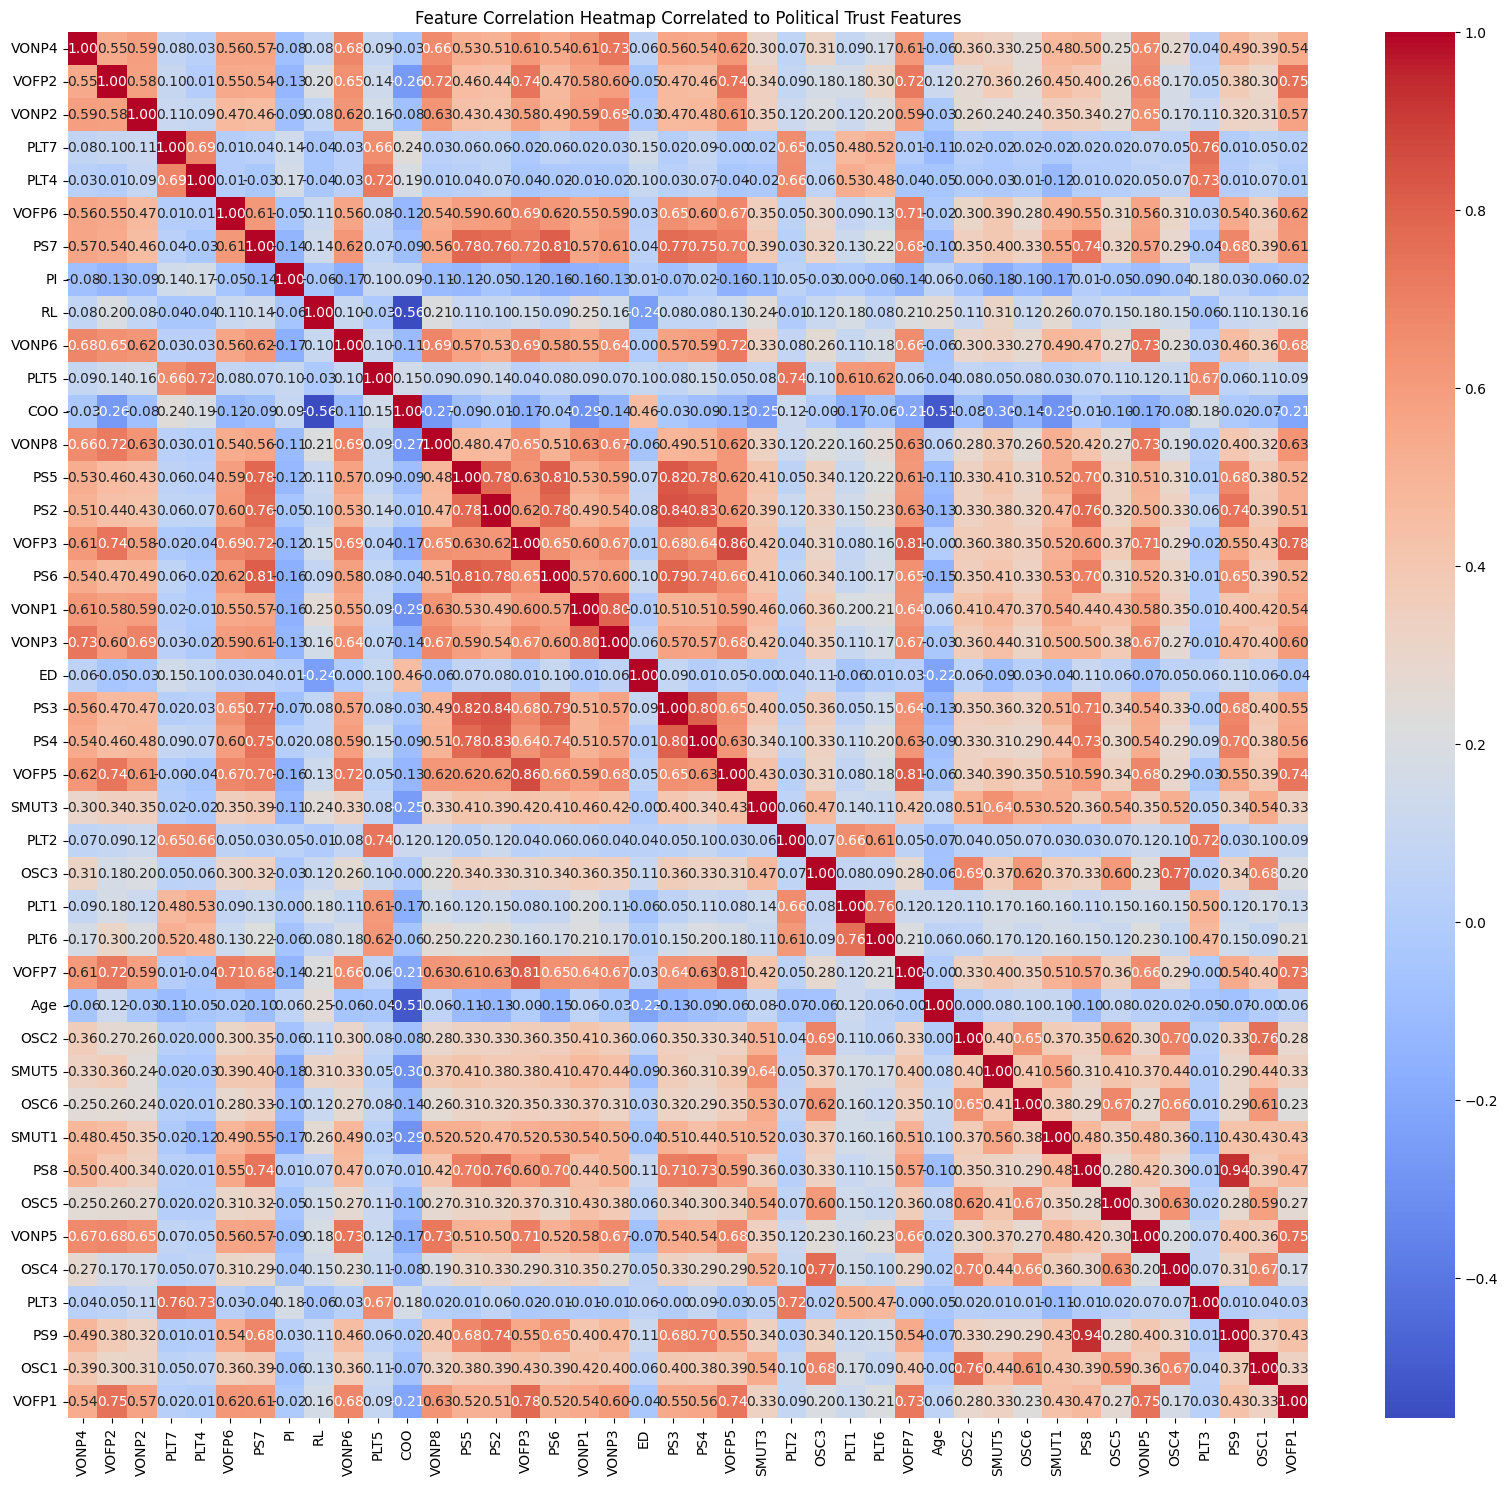

In [89]:
# Step 2: Feature Engineering
# Correlation matrix to identify relevant features
# Compute correlation matrix
correlation_matrix = df_filtered.corr()

# Plot heatmap
plt.figure(figsize=(20, 18))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap Correlated to Political Trust Features')
plt.show()

# Hypothesis Testing (Chi-Square Test)

In [90]:
#Chi-square test function

import numpy as np
import scipy.stats as stats

def chi_square_test(observed, alpha=0.05):
    chi2, p_value, dof, expected = stats.chi2_contingency(observed)
    critical_value = stats.chi2.ppf(1 - alpha, dof)
    reject_null = chi2 > critical_value

    return chi2, p_value, dof, expected, reject_null, critical_value

In [91]:
import numpy as np
from collections import defaultdict
from scipy.stats import chi2_contingency, chi2

def analyze_features(data, feature1, feature2, alpha=0.05):
    print(f"Analyzing features: {feature1} and {feature2}")
    """
    Analyzes the relationship between two features using the Chi-Square Test.

    Parameters:
        data (DataFrame): The dataset containing the features.
        feature1 (str): The name of the first feature.
        feature2 (str): The name of the second feature.
        alpha (float): The significance level for the Chi-Square Test.

    Returns:
        dict: Results containing the Chi-Square statistic, p-value, degrees of freedom,
              expected frequencies, and whether the null hypothesis is rejected.
    """
    # Initialize a dictionary to store counts
    counts = defaultdict(list)

    # Unique values of the features
    feature1_values = sorted(data[feature1].unique())
    feature2_values = sorted(data[feature2].unique())

    print(f"Unique values of {feature1}: {feature1_values}")
    print(f"Unique values of {feature2}: {feature2_values}")

    # Iterate through combinations of feature1 and feature2 values
    for val1 in feature1_values:
        for val2 in feature2_values:
            filtered_data = data[(data[feature1] == val1) & (data[feature2] == val2)]
            counts[val2].append(len(filtered_data))

    # Convert counts to arrays
    arrays = [counts[val2] for val2 in feature2_values]

    print(f"Counts for {feature2}: {arrays}")

    # Convert arrays to a numpy array
    observed = np.array(arrays)

    # Perform the Chi-Square Test
    chi2_stat, p_value, dof, expected, reject_null, critical_value= chi_square_test(observed)
    critical_value = chi2.ppf(1 - alpha, dof)
    reject_null = p_value < alpha

    # Print results
    print("Chi-Square Statistic:", chi2_stat)
    print("P-value:", p_value)
    print("Degrees of Freedom:", dof)
    print("Expected Frequencies:\n", expected)
    print("Critical Value (alpha=0.05):", critical_value)
    print("H0 " + ("Rejected" if reject_null else "Accepted"))

    # Return results as a dictionary
    return {
        "chi2_stat": chi2_stat,
        "p_value": p_value,
        "dof": dof,
        "expected": expected,
        "critical_value": critical_value,
        "reject_null": reject_null
    }


# Hypothesis 1
- H0: There is no association between PLT6 and VOFP2
- H1: There is association between PLT6 and VOFP2

In [92]:
chi_result = analyze_features(df_filtered, 'PLT6', 'VOFP2')

Analyzing features: PLT6 and VOFP2
Unique values of PLT6: [1, 2, 3, 4, 5]
Unique values of VOFP2: [1, 2, 3, 4, 5]
Counts for VOFP2: [[7, 4, 3, 2, 1], [3, 5, 8, 2, 2], [7, 17, 98, 10, 2], [4, 28, 45, 28, 19], [8, 26, 58, 43, 42]]
Chi-Square Statistic: 122.04537069693762
P-value: 2.2187514129831805e-18
Degrees of Freedom: 16
Expected Frequencies:
 [[ 1.04449153  2.88135593  7.63559322  3.06144068  2.37711864]
 [ 1.22881356  3.38983051  8.98305085  3.60169492  2.79661017]
 [ 8.23305085 22.71186441 60.18644068 24.13135593 18.73728814]
 [ 7.61864407 21.01694915 55.69491525 22.33050847 17.33898305]
 [10.875      30.         79.5        31.875      24.75      ]]
Critical Value (alpha=0.05): 26.29622760486423
H0 Rejected


With df = 16 and a significance level of 0.05, we can compare this total calculated chi-square value to the critical chi-square value (approximately 26.2962). Total Calculated Chi-Square (122.045) > Critical Chi-Square Value (26.2962) Since the total calculated chi-square value is greater than the critical chi-square value, we would reject the null hypothesis. This indicates that there is a significant association between PLT6 and VOFP2.

# Hypothesis 2
- H0: There is no association between PLT6 and VONP8
- H1: There is association between PLT6 and VONP8

In [93]:
chi_result = analyze_features(df_filtered, 'PLT6', 'VONP8')

Analyzing features: PLT6 and VONP8
Unique values of PLT6: [1, 2, 3, 4, 5]
Unique values of VONP8: [1, 2, 3, 4, 5]
Counts for VONP8: [[7, 3, 7, 3, 2], [4, 7, 15, 4, 3], [4, 18, 96, 6, 3], [4, 25, 47, 36, 18], [10, 27, 47, 36, 40]]
Chi-Square Statistic: 118.08694430169103
P-value: 1.2801146694629625e-17
Degrees of Freedom: 16
Expected Frequencies:
 [[ 1.35169492  3.72881356  9.88135593  3.96186441  3.07627119]
 [ 2.02754237  5.59322034 14.8220339   5.94279661  4.61440678]
 [ 7.8029661  21.52542373 57.04237288 22.87076271 17.75847458]
 [ 7.98728814 22.03389831 58.38983051 23.41101695 18.1779661 ]
 [ 9.83050847 27.11864407 71.86440678 28.81355932 22.37288136]]
Critical Value (alpha=0.05): 26.29622760486423
H0 Rejected


With df = 16 and a significance level of 0.05, we can compare this total calculated chi-square value to the critical chi-square value (approximately 26.2962). Total Calculated Chi-Square (118.087) > Critical Chi-Square Value (26.2962) Since the total calculated chi-square value is greater than the critical chi-square value, we would reject the null hypothesis. This indicates that there is a significant association between PLT6 and VONP8.

# Hypothesis 3
- H0: There is no association between PLT7 and COO
- H1: There is association between PLT7 and COO

In [94]:
chi_result = analyze_features(df_filtered, 'PLT7', 'COO')

Analyzing features: PLT7 and COO
Unique values of PLT7: [1, 2, 3, 4, 5]
Unique values of COO: [1, 2, 3]
Counts for COO: [[26, 69, 41, 14, 10], [6, 26, 100, 16, 11], [18, 33, 46, 28, 28]]
Chi-Square Statistic: 89.31690009406068
P-value: 6.399226116743773e-16
Degrees of Freedom: 8
Expected Frequencies:
 [[16.94915254 43.38983051 63.38983051 19.66101695 16.61016949]
 [16.84322034 43.11864407 62.99364407 19.53813559 16.50635593]
 [16.20762712 41.49152542 60.61652542 18.80084746 15.88347458]]
Critical Value (alpha=0.05): 15.50731305586545
H0 Rejected


With df = 8 and a significance level of 0.05, we can compare this total calculated chi-square value to the critical chi-square value (approximately 15.5077). Total Calculated Chi-Square (89.32) > Critical Chi-Square Value (15.507) Since the total calculated chi-square value is greater than the critical chi-square value, we would reject the null hypothesis. This indicates that there is a significant association between PLT7 and COO.

# Hypothesis 4
- H0: There is no association between PLT6 and PS2
- H1: There is association between PLT6 and PS2

In [95]:
chi_result = analyze_features(df_filtered, 'PLT6', 'PS2')

Analyzing features: PLT6 and PS2
Unique values of PLT6: [1, 2, 3, 4, 5]
Unique values of PS2: [1, 2, 3, 4, 5]
Counts for PS2: [[10, 11, 63, 6, 8], [11, 25, 48, 20, 10], [4, 19, 47, 13, 11], [1, 16, 19, 29, 17], [3, 9, 35, 17, 20]]
Chi-Square Statistic: 69.72474028607829
P-value: 1.1150074103832124e-08
Degrees of Freedom: 16
Expected Frequencies:
 [[ 6.02118644 16.61016949 44.01694915 17.64830508 13.70338983]
 [ 7.00423729 19.3220339  51.20338983 20.52966102 15.94067797]
 [ 5.77542373 15.93220339 42.22033898 16.9279661  13.1440678 ]
 [ 5.03813559 13.89830508 36.83050847 14.76694915 11.46610169]
 [ 5.16101695 14.23728814 37.72881356 15.12711864 11.74576271]]
Critical Value (alpha=0.05): 26.29622760486423
H0 Rejected


With df = 16 and a significance level of 0.05, we can compare this total calculated chi-square value to the critical chi-square value (approximately 26.2962). Total Calculated Chi-Square (69.72) > Critical Chi-Square Value (26.2962) Since the total calculated chi-square value is greater than the critical chi-square value, we would reject the null hypothesis. This indicates that there is a significant association between PLT6 and PS2.

# Hypothesis 5
- H0: There is no association between PLT6 and VONP5
- H1: There is association between PLT6 and VONP5

In [96]:
chi_result = analyze_features(df_filtered, 'PLT6', 'VONP5')

Analyzing features: PLT6 and VONP5
Unique values of PLT6: [1, 2, 3, 4, 5]
Unique values of VONP5: [1, 2, 3, 4, 5]
Counts for VONP5: [[6, 6, 16, 2, 4], [5, 11, 19, 6, 3], [5, 19, 87, 10, 5], [3, 23, 48, 37, 21], [10, 21, 42, 30, 33]]
Chi-Square Statistic: 80.79937224360098
P-value: 1.1938488339072136e-10
Degrees of Freedom: 16
Expected Frequencies:
 [[ 2.08898305  5.76271186 15.27118644  6.12288136  4.75423729]
 [ 2.70338983  7.45762712 19.76271186  7.92372881  6.15254237]
 [ 7.74152542 21.3559322  56.59322034 22.69067797 17.61864407]
 [ 8.11016949 22.37288136 59.28813559 23.77118644 18.45762712]
 [ 8.3559322  23.05084746 61.08474576 24.49152542 19.01694915]]
Critical Value (alpha=0.05): 26.29622760486423
H0 Rejected


With df = 16 and a significance level of 0.05, we can compare this total calculated chi-square value to the critical chi-square value (approximately 26.2962). Total Calculated Chi-Square (80.7994) > Critical Chi-Square Value (26.2962) Since the total calculated chi-square value is greater than the critical chi-square value, we would reject the null hypothesis. This indicates that there is a significant association between PLT6 and VONP5.

# Hypothesis 6
- H0: There is no association between PLT6 and PS7
- H1: There is association between PLT6 and PS7

In [97]:
chi_result = analyze_features(df_filtered, 'PLT6', 'PS7')

Analyzing features: PLT6 and PS7
Unique values of PLT6: [1, 2, 3, 4, 5]
Unique values of PS7: [1, 2, 3, 4, 5]
Counts for PS7: [[5, 10, 63, 3, 6], [7, 13, 25, 7, 4], [9, 14, 44, 12, 7], [4, 24, 39, 32, 23], [4, 19, 41, 31, 26]]
Chi-Square Statistic: 70.73574870163999
P-value: 7.4142750324629325e-09
Degrees of Freedom: 16
Expected Frequencies:
 [[ 5.34533898 14.74576271 39.07627119 15.66737288 12.16525424]
 [ 3.44067797  9.49152542 25.15254237 10.08474576  7.83050847]
 [ 5.28389831 14.57627119 38.62711864 15.48728814 12.02542373]
 [ 7.49576271 20.6779661  54.79661017 21.97033898 17.05932203]
 [ 7.43432203 20.50847458 54.34745763 21.79025424 16.91949153]]
Critical Value (alpha=0.05): 26.29622760486423
H0 Rejected


With df = 16 and a significance level of 0.05, we can compare this total calculated chi-square value to the critical chi-square value (approximately 26.2962). Total Calculated Chi-Square (70.7357) > Critical Chi-Square Value (26.2962) Since the total calculated chi-square value is greater than the critical chi-square value, we would reject the null hypothesis. This indicates that there is a significant association between PLT6 and PS7.

# Hypothesis 7
- H0: There is no association between PLT6 and PS5
- H1: There is association between PLT6 and PS5

In [98]:
chi_result = analyze_features(df_filtered, 'PLT6', 'PS5')

Analyzing features: PLT6 and PS5
Unique values of PLT6: [1, 2, 3, 4, 5]
Unique values of PS5: [1, 2, 3, 4, 5]
Counts for PS5: [[4, 10, 58, 1, 6], [10, 17, 32, 15, 10], [12, 25, 48, 21, 10], [1, 17, 39, 26, 20], [2, 11, 35, 22, 20]]
Chi-Square Statistic: 65.00752334231473
P-value: 7.344783026543038e-08
Degrees of Freedom: 16
Expected Frequencies:
 [[ 4.85381356 13.38983051 35.48305085 14.22669492 11.04661017]
 [ 5.16101695 14.23728814 37.72881356 15.12711864 11.74576271]
 [ 7.12711864 19.66101695 52.10169492 20.88983051 16.22033898]
 [ 6.32838983 17.45762712 46.26271186 18.54872881 14.40254237]
 [ 5.52966102 15.25423729 40.42372881 16.20762712 12.58474576]]
Critical Value (alpha=0.05): 26.29622760486423
H0 Rejected


With df = 16 and a significance level of 0.05, we can compare this total calculated chi-square value to the critical chi-square value (approximately 26.2962). Total Calculated Chi-Square (65.0075) > Critical Chi-Square Value (26.2962) Since the total calculated chi-square value is greater than the critical chi-square value, we would reject the null hypothesis. This indicates that there is a significant association between PLT6 and PS5.

# Hypothesis 8
- H0: There is no association between PLT6 and VONP1
- H1: There is association between PLT6 and VONP1

In [99]:
chi_result = analyze_features(df_filtered, 'PLT6', 'VONP1')

Analyzing features: PLT6 and VONP1
Unique values of PLT6: [1, 2, 3, 4, 5]
Unique values of VONP1: [1, 2, 3, 4, 5]
Counts for VONP1: [[10, 4, 18, 3, 4], [9, 24, 74, 15, 12], [3, 14, 52, 19, 11], [3, 21, 43, 25, 15], [4, 17, 25, 23, 24]]
Chi-Square Statistic: 64.62723225669897
P-value: 8.538135677576367e-08
Degrees of Freedom: 16
Expected Frequencies:
 [[ 2.39618644  6.61016949 17.51694915  7.02330508  5.45338983]
 [ 8.23305085 22.71186441 60.18644068 24.13135593 18.73728814]
 [ 6.08262712 16.77966102 44.46610169 17.82838983 13.84322034]
 [ 6.57415254 18.13559322 48.05932203 19.2690678  14.96186441]
 [ 5.71398305 15.76271186 41.77118644 16.74788136 13.00423729]]
Critical Value (alpha=0.05): 26.29622760486423
H0 Rejected


With df = 16 and a significance level of 0.05, we can compare this total calculated chi-square value to the critical chi-square value (approximately 26.2962). Total Calculated Chi-Square (64.6272) > Critical Chi-Square Value (26.2962) Since the total calculated chi-square value is greater than the critical chi-square value, we would reject the null hypothesis. This indicates that there is a significant association between PLT6 and VONP1.

# Hypothesis 9
- H0: There is no association between PLT6 and VOFP7
- H1: There is association between PLT6 and VOFP7

In [100]:
chi_result = analyze_features(df_filtered, 'PLT6', 'VOFP7')

Analyzing features: PLT6 and VOFP7
Unique values of PLT6: [1, 2, 3, 4, 5]
Unique values of VOFP7: [1, 2, 3, 4, 5]
Counts for VOFP7: [[10, 8, 43, 5, 3], [8, 10, 53, 16, 5], [2, 11, 31, 8, 6], [4, 22, 43, 32, 19], [5, 29, 42, 24, 33]]
Chi-Square Statistic: 65.33505034786975
P-value: 6.450445388555007e-08
Degrees of Freedom: 16
Expected Frequencies:
 [[ 4.23940678 11.69491525 30.99152542 12.42584746  9.64830508]
 [ 5.65254237 15.59322034 41.3220339  16.56779661 12.86440678]
 [ 3.56355932  9.83050847 26.05084746 10.44491525  8.11016949]
 [ 7.37288136 20.33898305 53.89830508 21.61016949 16.77966102]
 [ 8.17161017 22.54237288 59.73728814 23.95127119 18.59745763]]
Critical Value (alpha=0.05): 26.29622760486423
H0 Rejected


With df = 16 and a significance level of 0.05, we can compare this total calculated chi-square value to the critical chi-square value (approximately 26.2962). Total Calculated Chi-Square (65.3350) > Critical Chi-Square Value (26.2962) Since the total calculated chi-square value is greater than the critical chi-square value, we would reject the null hypothesis. This indicates that there is a significant association between PLT6 and VOFP7.

# Hypothesis 10
- H0: There is no association between PLT6 and VOFP1
- H1: There is association between PLT6 and VOFP1

In [101]:
chi_result = analyze_features(df_filtered, 'PLT6', 'VOFP1')

Analyzing features: PLT6 and VOFP1
Unique values of PLT6: [1, 2, 3, 4, 5]
Unique values of VOFP1: [1, 2, 3, 4, 5]
Counts for VOFP1: [[8, 8, 13, 4, 3], [9, 9, 23, 7, 12], [1, 15, 87, 13, 4], [5, 23, 46, 26, 14], [6, 25, 43, 35, 33]]
Chi-Square Statistic: 93.13035687595156
P-value: 6.605623684108595e-13
Degrees of Freedom: 16
Expected Frequencies:
 [[ 2.21186441  6.10169492 16.16949153  6.48305085  5.03389831]
 [ 3.68644068 10.16949153 26.94915254 10.80508475  8.38983051]
 [ 7.37288136 20.33898305 53.89830508 21.61016949 16.77966102]
 [ 7.00423729 19.3220339  51.20338983 20.52966102 15.94067797]
 [ 8.72457627 24.06779661 63.77966102 25.5720339  19.8559322 ]]
Critical Value (alpha=0.05): 26.29622760486423
H0 Rejected


With df = 16 and a significance level of 0.05, we can compare this total calculated chi-square value to the critical chi-square value (approximately 26.2962). Total Calculated Chi-Square (93.130) > Critical Chi-Square Value (26.2962) Since the total calculated chi-square value is greater than the critical chi-square value, we would reject the null hypothesis. This indicates that there is a significant association between PLT6 and VOFP1.

# Hypothesis 11
- H0: There is no association between PLT6 and VONP2
- H1: There is association between PLT6 and VONP2

In [102]:
chi_result = analyze_features(df_filtered, 'PLT6', 'VONP2')

Analyzing features: PLT6 and VONP2
Unique values of PLT6: [1, 2, 3, 4, 5]
Unique values of VONP2: [1, 2, 3, 4, 5]
Counts for VONP2: [[6, 3, 6, 3, 2], [3, 9, 17, 9, 6], [6, 20, 103, 12, 3], [8, 27, 40, 35, 21], [6, 21, 46, 26, 34]]
Chi-Square Statistic: 97.01372152642779
P-value: 1.2529760964897923e-13
Degrees of Freedom: 16
Expected Frequencies:
 [[ 1.22881356  3.38983051  8.98305085  3.60169492  2.79661017]
 [ 2.70338983  7.45762712 19.76271186  7.92372881  6.15254237]
 [ 8.84745763 24.40677966 64.6779661  25.93220339 20.13559322]
 [ 8.04872881 22.20338983 58.83898305 23.59110169 18.31779661]
 [ 8.17161017 22.54237288 59.73728814 23.95127119 18.59745763]]
Critical Value (alpha=0.05): 26.29622760486423
H0 Rejected


With df = 16 and a significance level of 0.05, we can compare this total calculated chi-square value to the critical chi-square value (approximately 26.2962). Total Calculated Chi-Square (97.013) > Critical Chi-Square Value (26.2962) Since the total calculated chi-square value is greater than the critical chi-square value, we would reject the null hypothesis. This indicates that there is a significant association between PLT6 and VONP2.

# Hypothesis 12
- H0: There is no association between PLT6 and PS4
- H1: There is association between PLT6 and PS4

In [103]:
chi_result = analyze_features(df_filtered, 'PLT6', 'PS4')

Analyzing features: PLT6 and PS4
Unique values of PLT6: [1, 2, 3, 4, 5]
Unique values of PS4: [1, 2, 3, 4, 5]
Counts for PS4: [[7, 5, 21, 3, 6], [5, 23, 52, 14, 7], [9, 14, 62, 13, 9], [4, 25, 44, 35, 22], [4, 13, 33, 20, 22]]
Chi-Square Statistic: 51.54268054588832
P-value: 1.2980053253358228e-05
Degrees of Freedom: 16
Expected Frequencies:
 [[ 2.58050847  7.11864407 18.86440678  7.56355932  5.87288136]
 [ 6.20550847 17.11864407 45.36440678 18.18855932 14.12288136]
 [ 6.57415254 18.13559322 48.05932203 19.2690678  14.96186441]
 [ 7.98728814 22.03389831 58.38983051 23.41101695 18.1779661 ]
 [ 5.65254237 15.59322034 41.3220339  16.56779661 12.86440678]]
Critical Value (alpha=0.05): 26.29622760486423
H0 Rejected


With df = 16 and a significance level of 0.05, we can compare this total calculated chi-square value to the critical chi-square value (approximately 26.2962). Total Calculated Chi-Square (51.5427) > Critical Chi-Square Value (26.2962) Since the total calculated chi-square value is greater than the critical chi-square value, we would reject the null hypothesis. This indicates that there is a significant association between PLT6 and PS4.

In [104]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [105]:
# Evaluation function to print the metrics
def evaluate_model(y_test, y_pred, model_name):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

    print(f"Model: {model_name}")
    print(confusion_matrix(y_test, y_pred))
    print(f"{model_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}\n")

def modelClassification(X, y, X_train, X_test, y_train, y_test):

# Random Forest
    rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=1, min_samples_split=10, random_state=42)
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)
    # Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


# Support Vector Machine (SVM)
    svm_model = SVC(kernel='rbf')
    svm_model.fit(X_train, y_train)
    y_pred_svm = svm_model.predict(X_test)

# Neural Network
    nn_model = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=300)
    nn_model.fit(X_train, y_train)
    y_pred_nn = nn_model.predict(X_test)

# XGBoost
    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)

# Logistic Regression
    lr_model = LogisticRegression()
    lr_model.fit(X_train, y_train)
    y_pred_lr = lr_model.predict(X_test)

# Evaluating all models
    evaluate_model(y_test, y_pred_rf, 'Random Forest')
    evaluate_model(y_test, y_pred_svm, 'SVM')
    evaluate_model(y_test, y_pred_nn, 'Neural Network')
    evaluate_model(y_test, y_pred_xgb, 'XGBoost')
    evaluate_model(y_test, y_pred_lr, 'Logistic Regression')


    return xgb_model, rf_model, svm_model, nn_model, lr_model, y_pred_xgb, y_pred_rf, y_pred_svm, y_pred_nn, y_pred_lr

In [106]:
y = df_filtered['PLT6']
X = df_filtered.drop(['PLT6'], axis=1)

# Map labels to start from 0
y_mapped = y - y.min()

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_mapped, test_size=0.3, random_state=42)
xgb_model, rf_model, svm_model, nn_model, lr_model, y_pred_xgb, y_pred_rf, y_pred_svm, y_pred_nn, y_pred_lr = modelClassification(X, y, X_train, X_test, y_train, y_test)


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:21:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model: Random Forest
[[ 2  1  4  0  0]
 [ 0 16  4  3  0]
 [ 0  9 49  0  1]
 [ 0  2 14 11  1]
 [ 0  0  4  5 16]]
Random Forest Performance:
Accuracy: 0.6620
Precision: 0.7385
Recall: 0.5689
F1-Score: 0.6031

Model: SVM
[[ 2  1  4  0  0]
 [ 1  5 17  0  0]
 [ 0  7 51  0  1]
 [ 0  2 24  0  2]
 [ 0  0 14  1 10]]
SVM Performance:
Accuracy: 0.4789
Precision: 0.4466
Recall: 0.3535
F1-Score: 0.3586

Model: Neural Network
[[ 2  0  4  1  0]
 [ 2  9  8  4  0]
 [ 2  6 43  4  4]
 [ 1  4 13  7  3]
 [ 0  0  3  3 19]]
Neural Network Performance:
Accuracy: 0.5634
Precision: 0.4928
Recall: 0.4832
F1-Score: 0.4838

Model: XGBoost
[[ 4  0  3  0  0]
 [ 2 12  5  4  0]
 [ 2  7 46  3  1]
 [ 0  2 11 13  2]
 [ 0  0  1  7 17]]
XGBoost Performance:
Accuracy: 0.6479
Precision: 0.6200
Recall: 0.6034
F1-Score: 0.6086

Model: Logistic Regression
[[ 4  0  1  1  1]
 [ 4  7  7  2  3]
 [ 2  6 44  3  4]
 [ 1  3 13  6  5]
 [ 0  0  2  5 18]]
Logistic Regression Performance:
Accuracy: 0.5563
Precision: 0.4783
Recall: 0.5112
F

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [107]:
import pandas as pd

# Create a dictionary to store results
model_results = {
    "Model": ["Logistic Regression", "Random Forest", "SVM", "XGBoost", "Neural Network"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_svm),
        accuracy_score(y_test, y_pred_xgb),
        accuracy_score(y_test, y_pred_nn)
    ],
    "Precision": [
        precision_score(y_test, y_pred_lr, average='macro', zero_division=0),
        precision_score(y_test, y_pred_rf, average='macro', zero_division=0),
        precision_score(y_test, y_pred_svm, average='macro', zero_division=0),
        precision_score(y_test, y_pred_xgb, average='macro', zero_division=0),
        precision_score(y_test, y_pred_nn, average='macro', zero_division=0)
    ],
    "Recall": [
        recall_score(y_test, y_pred_lr, average='macro', zero_division=0),
        recall_score(y_test, y_pred_rf, average='macro', zero_division=0),
        recall_score(y_test, y_pred_svm, average='macro', zero_division=0),
        recall_score(y_test, y_pred_xgb, average='macro', zero_division=0),
        recall_score(y_test, y_pred_nn, average='macro', zero_division=0)
    ],
    "F1-Score": [
        f1_score(y_test, y_pred_lr, average='macro', zero_division=0),
        f1_score(y_test, y_pred_rf, average='macro', zero_division=0),
        f1_score(y_test, y_pred_svm, average='macro', zero_division=0),
        f1_score(y_test, y_pred_xgb, average='macro', zero_division=0),
        f1_score(y_test, y_pred_nn, average='macro', zero_division=0)
    ]
}

# Create a DataFrame for comparison
comparison_df = pd.DataFrame(model_results)

# Optionally display the table nicely (if in a Jupyter Notebook/Colab environment)
from IPython.display import display
display(comparison_df)


Model  Accuracy  Precision    Recall  F1-Score
0  Logistic Regression  0.556338   0.478288  0.511165  0.482271
1        Random Forest  0.661972   0.738520  0.568946  0.603102
2                  SVM  0.478873   0.446573  0.353502  0.358605
3              XGBoost  0.647887   0.619976  0.603423  0.608614
4       Neural Network  0.563380   0.492845  0.483166  0.483759

In [108]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
# Model Selection: Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Hyperparameter Tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best Parameters and Performance
best_rf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Evaluate on Test Data
y_pred = best_rf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.29      0.44         7
           1       0.59      0.74      0.65        23
           2       0.65      0.81      0.72        59
           3       0.58      0.39      0.47        28
           4       0.89      0.64      0.74        25

    accuracy                           0.66       142
   macro avg       0.74      0.57      0.61       142
weighted avg       0.68      0.66      0.65       142



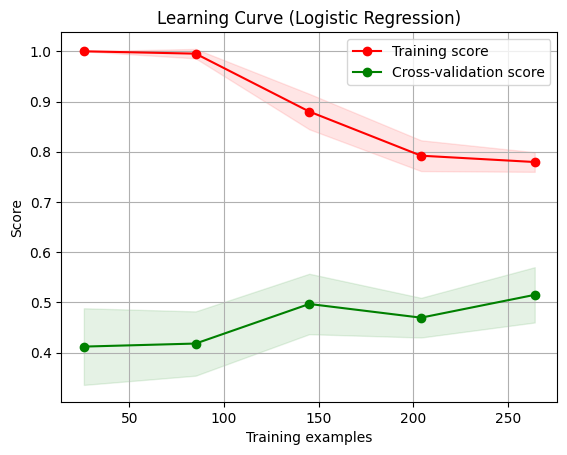

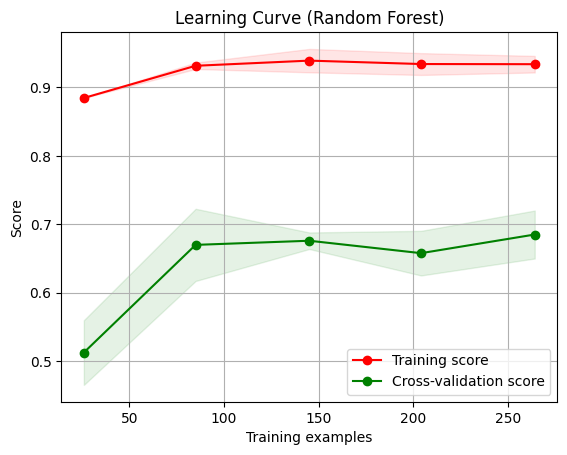

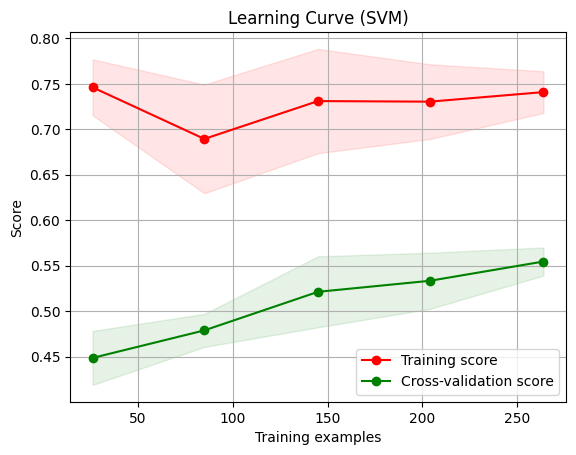

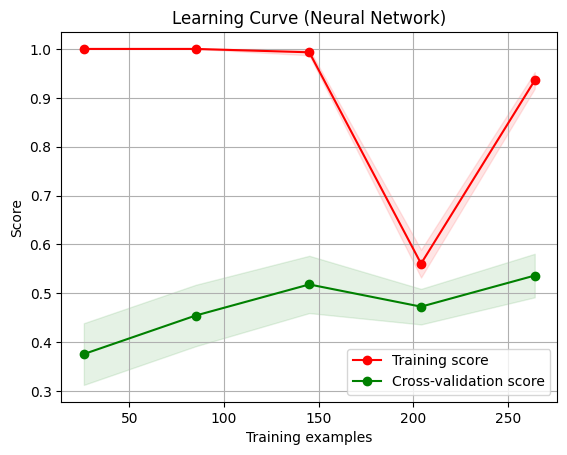

In [109]:
!pip install --upgrade scikit-learn xgboost

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Plot learning curves for each model
plot_learning_curve(lr_model, "Learning Curve (Logistic Regression)", X_train, y_train)
plot_learning_curve(rf_model, "Learning Curve (Random Forest)", X_train, y_train)
plot_learning_curve(svm_model, "Learning Curve (SVM)", X_train, y_train)
plot_learning_curve(nn_model, "Learning Curve (Neural Network)", X_train, y_train)

plt.show()

In [110]:
import shap

# Ensure the rf model is trained with probability=True
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=1, min_samples_split=10, random_state=42)
rf_model.fit(X_train, y_train)

# SHAP analysis for rf
explainer_rf = shap.KernelExplainer(rf_model.predict_proba, X_train[:10])
shap_values_rf = explainer_rf.shap_values(X_train)

# Visualize the first prediction's explanation for rf
shap.initjs()
shap.force_plot(explainer_rf.expected_value[0], shap_values_rf[0,:,0], X_train.iloc[0,:])

  0%|          | 0/330 [00:00<?, ?it/s]

 95%|=================== | 678/710 [00:13<00:00]       

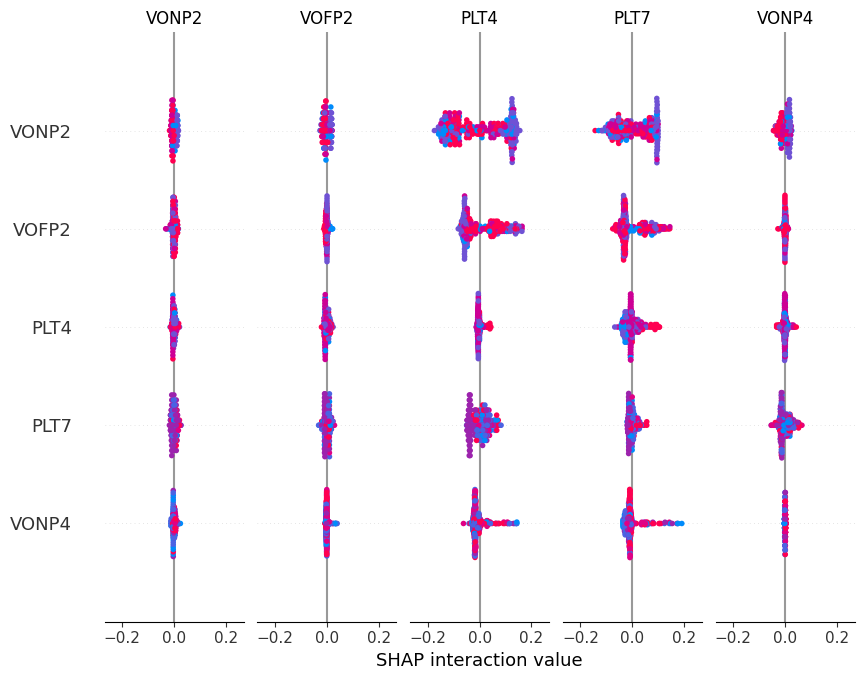

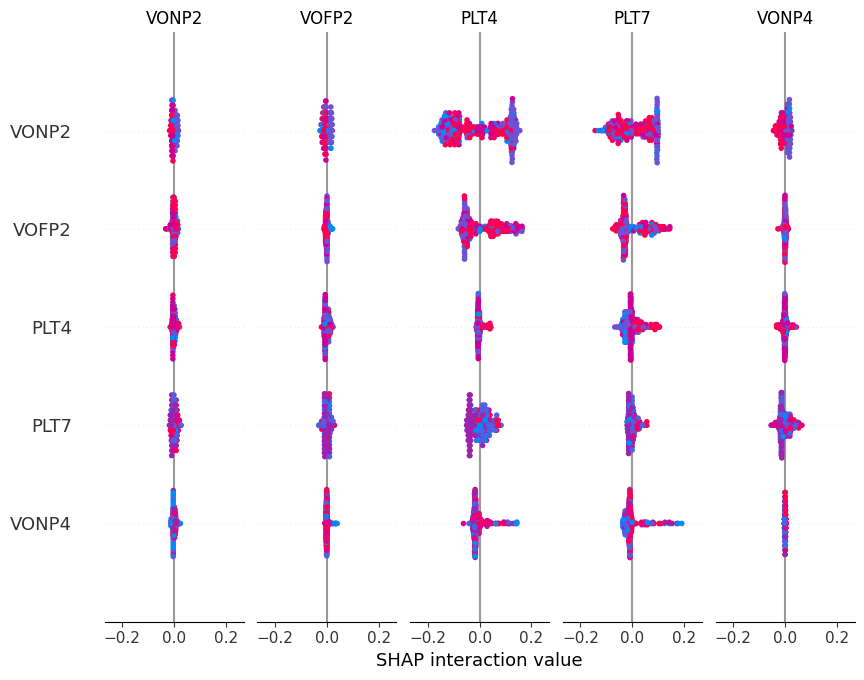

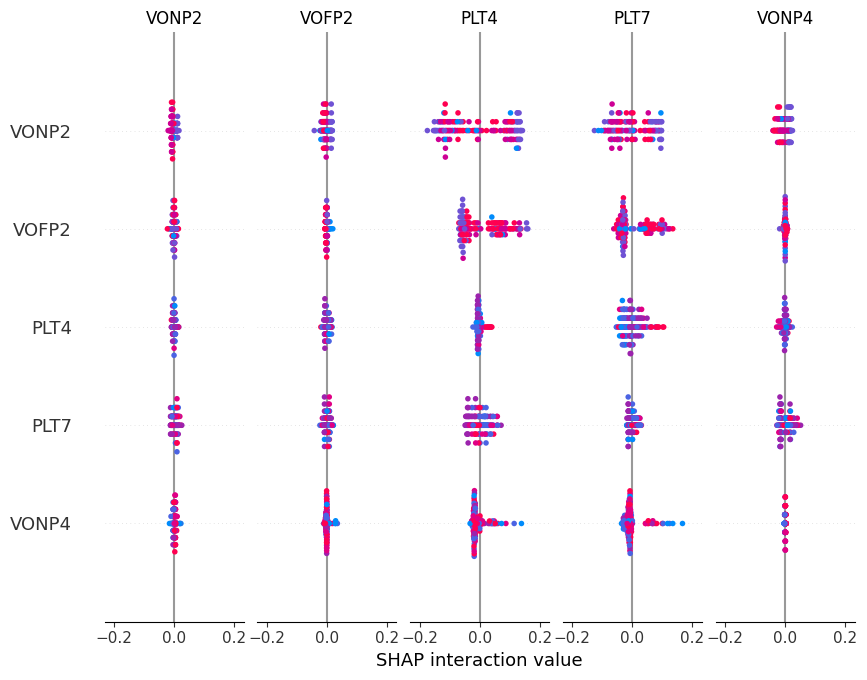

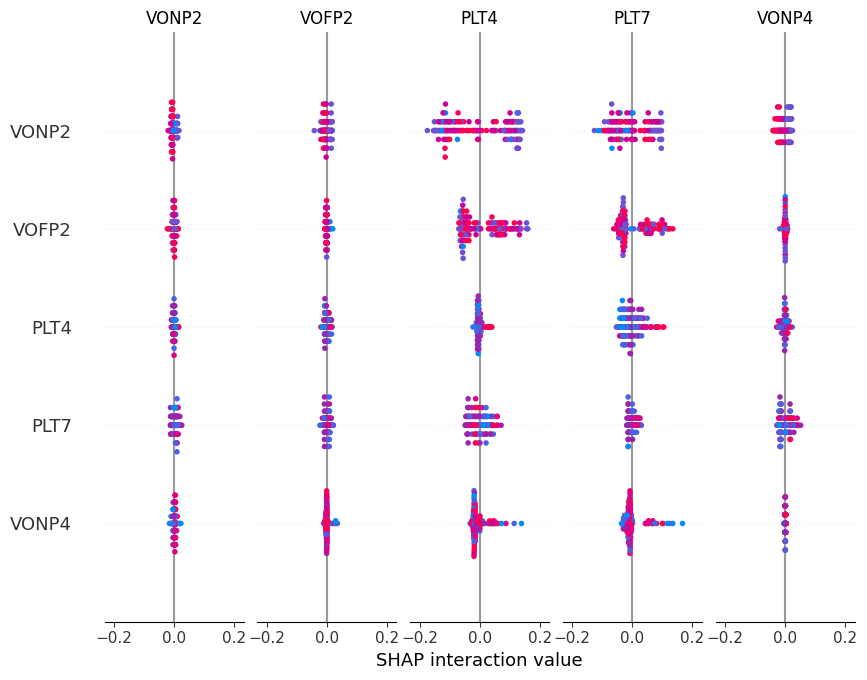

In [111]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import shap

# Separate features and target
X = df_filtered.drop(columns=['PLT6'])  # Assuming 'Address' is not a numeric feature
Y = df_filtered['PLT6']

# Map labels to start from 0
y_mapped = y - y.min()

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y_mapped, test_size=0.3, random_state=42)

# Initialize the XGBRegressor with specified parameters
rf_classifier = RandomForestClassifier(n_estimators=100,
                                       max_depth=10,
                                       min_samples_leaf=1,
                                       min_samples_split=10,
                                       random_state=42
                                       )

# Fit the model
rf_classifier.fit(x_train, y_train)

# Compute SHAP values
# Pass x_train to the explainer, ensuring consistency with the training data
explainer = shap.Explainer(rf_classifier, x_train)
shap_values = explainer(x_train) # Explain the training data

# If you also need SHAP values for the test data, calculate them separately
# but remember to disable the additivity check for x_test since it was scaled
shap_values_test = explainer(x_test, check_additivity=False)

# Visualizations for training data
shap.summary_plot(shap_values, x_train, plot_type="bar", feature_names=X.columns)  # Summary bar plot
shap.summary_plot(shap_values, x_train, plot_type="dot", feature_names=X.columns)  # Summary bee-swarm plot

# Visualizations for test data (if needed) - disable additivity check
shap.summary_plot(shap_values_test, x_test, plot_type="bar", feature_names=X.columns)
shap.summary_plot(shap_values_test, x_test, plot_type="dot", feature_names=X.columns)